In [1]:
#Run below once to install required packages
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install scipy
!pip install numpy
!pip install seaborn
!pip install xgboost
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Run below once to import required packages
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold

/tmp/ipykernel_228008/3851669549.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mma_fights['time'] = pd.to_numeric(mma_dataframe['minutes']) * 60 + pd.to_numeric(mma_dataframe['seconds'])


[LightGBM] [Info] Number of positive: 4458, number of negative: 4582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4473
[LightGBM] [Info] Number of data points in the train set: 9040, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493142 -> initscore=-0.027435
[LightGBM] [Info] Start training from score -0.027435


<Axes: >

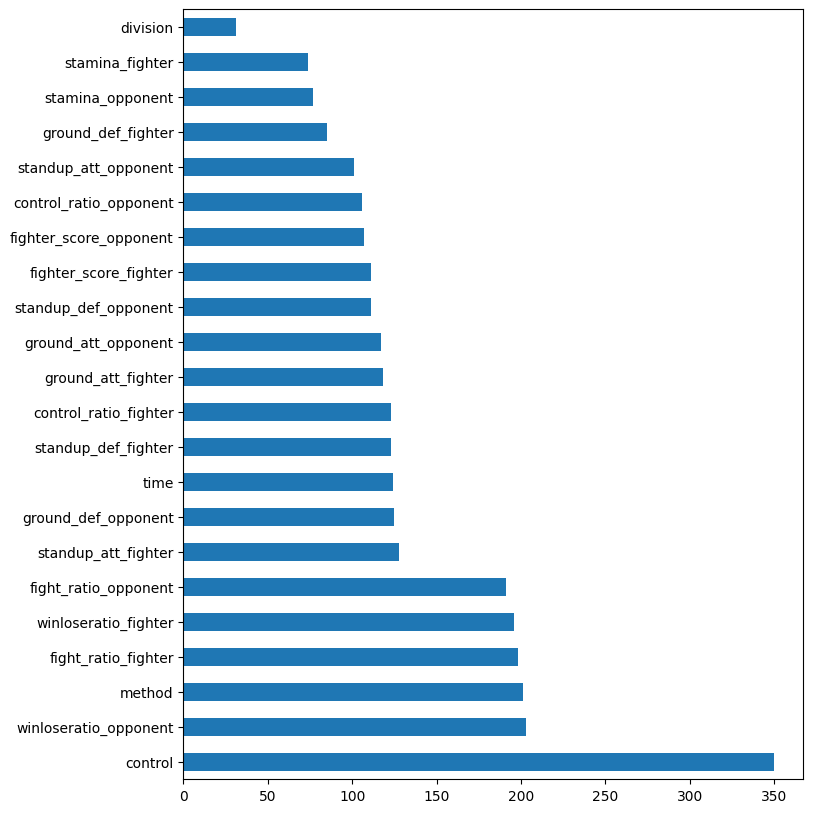

In [3]:
#Constants
TESTSIZE = 0.1  # % of data will be used for testing.
VALIDSPLITSIZE = 0.1  # % of data will be used for validation.
MIN_MATCH_COUNT = 2 # Minimum amount of matches player has to have done in order to be used in data

#Define features
staticFeatures = [
    "date",
    "method",
    "control",
    'fighter',
    'opponent',
    'division',
    "time_format",
    "result"
]
skillFeatures = [
    "ground_att",
    "ground_def",
    "standup_att",
    "standup_def",
    "fighter_score",
    "stamina",
    "fight_ratio",
    "winloseratio",
    "control_ratio"
]

extra_features = [
    "division",
    "control",
    "time",
    "method"
]

fightStr = "fighter"

#Import data
mma_dataframe = pd.read_csv('../dataset/masterdataframe.csv', parse_dates=True)
mma_fights = mma_dataframe[staticFeatures]
fighters_list = pd.DataFrame(mma_dataframe.drop_duplicates(fightStr)[fightStr])
feature_cols = mma_dataframe.columns

#Prepare datasets
fighters_list["matchcount"] = fighters_list.fighter.map(mma_dataframe.fighter.value_counts())
fighters_list = fighters_list.drop_duplicates(fightStr)
fighters_list = fighters_list.set_index(fightStr)
selected_fighters = pd.DataFrame(fighters_list.index[fighters_list["matchcount"] > MIN_MATCH_COUNT])
mma_dataframe[['minutes', 'seconds']] = mma_dataframe['time'].str.split(':', expand=True)
mma_fights['time'] = pd.to_numeric(mma_dataframe['minutes']) * 60 + pd.to_numeric(mma_dataframe['seconds'])

def fighter_statistics(fighter): 
    # Prepare helper functions
    def col_for_fighter(col): return mma_dataframe[col][forFighter]
    def matchAfter(seconds): return mma_dataframe["total_comp_time"] > seconds
    def matchBefore(seconds): return mma_dataframe["total_comp_time"] <= seconds
    def normalize(score): return max(0, score)
    def minimumOne(value): return max(1, value)

    # Prepare multiuse variables
    forFighter = (mma_dataframe[fightStr] == fighter)                      # For specific fighter
    lost = (mma_dataframe["result"]==0)                                    # Lost match
    won = (mma_dataframe["result"]==1)                                     # Won match
    withSub = (mma_dataframe["method"]=="SUB")                             # By submission
    withKO = (mma_dataframe["method"]=="KO/TKO")                           # By KO
    result = (mma_dataframe["result"])                                     # Match outcome
    num_fights = fighters_list.loc[fighter]["matchcount"]                  # Number of fights
    matchtime_total = col_for_fighter("total_comp_time").sum()             # Total matchtime   
    ground_time = col_for_fighter("control").sum()                         # Control time
    standup_time = matchtime_total - col_for_fighter("control").sum()      # Standup time

    def fight_ratio():
        return ground_time / standup_time

    def control_ratio():
        controls = col_for_fighter("control").mean()
        return (controls / num_fights) / 2

    def standup_att():
        knockdowns = col_for_fighter('knockdowns').sum()
        sig_strikes_accuracy = col_for_fighter('sig_strikes_landed').mean()
        total_strikes_accuracy = col_for_fighter('total_strikes_landed').mean()
        head_strikes_accuracy = col_for_fighter('head_strikes_landed').mean()
        body_strikes_accuracy = col_for_fighter('body_strikes_landed').mean()
        leg_strikes_accuracy = col_for_fighter('leg_strikes_landed').mean()
        distance_strikes_accuracy = col_for_fighter('distance_strikes_landed').mean()
        clinch_strikes_accuracy = col_for_fighter('clinch_strikes_landed').mean()

        return (sig_strikes_accuracy + total_strikes_accuracy + head_strikes_accuracy + body_strikes_accuracy + leg_strikes_accuracy + distance_strikes_accuracy + clinch_strikes_accuracy) / 8 + knockdowns * 0.1

    def stamina():
        win_second_round= result[forFighter & matchAfter(300) & matchBefore(600)].sum()
        win_third_round= result[forFighter & matchAfter(600) & matchBefore(900)].sum()
        win_champ_round= result[forFighter & matchAfter(900)].sum()

        fights_second_round= result[forFighter & matchAfter(300) & matchBefore(600)].count()
        fights_third_round= result[forFighter & matchAfter(600) & matchBefore(900)].count()
        fights_champ_round= result[forFighter & matchAfter(900)].count()

        total_stamina = np.array([
            (0.2 * win_second_round / minimumOne(fights_second_round)),
            (0.6 * win_third_round / minimumOne(fights_third_round)),
            (win_champ_round / minimumOne(fights_champ_round))
        ]).sum()
        return normalize(total_stamina)

    def winloseratio():
        last_three_won = won[forFighter][-20:].sum()
        last_three_lost = lost[forFighter][-20:].sum()
    
        if last_three_lost == 0: 
            return 1 
        else:
            return last_three_won / last_three_lost

    def standup_def():
        sig_strikes_def = col_for_fighter('sig_strikes_def').mean()
        total_strikes_def = col_for_fighter('total_strikes_def').mean()
        head_strikes_def = col_for_fighter('head_strikes_def').mean()
        body_strikes_def = col_for_fighter('body_strikes_def').mean()
        leg_strikes_def = col_for_fighter('leg_strikes_def').mean()
        distance_strikes_def = col_for_fighter('distance_strikes_def').mean()
        clinch_strikes_def = col_for_fighter('clinch_strikes_def').mean()

        return (sig_strikes_def + total_strikes_def + head_strikes_def + body_strikes_def + leg_strikes_def + distance_strikes_def + clinch_strikes_def) / 8

    def ground_att():
        avg_takedowns_accuracy = col_for_fighter('takedowns_landed').mean()
        ground_strikes_accuracy = col_for_fighter('ground_strikes_landed').mean()
        control = col_for_fighter('control').mean()
        sub_attempts = col_for_fighter('avg_sub_attempts').mean()
        ground_skill_score = (control + sub_attempts + avg_takedowns_accuracy + ground_strikes_accuracy) / 4

        return ground_skill_score

    def ground_def():
        takedowns_def = col_for_fighter('takedowns_def').mean()
        ground_strikes_def = col_for_fighter('ground_strikes_def').mean()
        reversals = col_for_fighter('reversals').mean()
        return (takedowns_def + ground_strikes_def + reversals) / 3
    
    def fighter_score():
        LAST_MATCHES = 4 # Use last x matches of fighter
        score = 0
        multiplier = 0.4
        results = col_for_fighter("result")
        for matchResult in results[:LAST_MATCHES:-1]:
            if matchResult == 1: # Won match
                score += multiplier
            else:
                score -= multiplier
            multiplier += 0.4
        return score

    return fight_ratio(), ground_att(), ground_def(), standup_att(), standup_def(), fighter_score(), stamina(), winloseratio(), control_ratio()

selected_fighters[skillFeatures] = selected_fighters[fightStr].apply(fighter_statistics).apply(pd.Series).astype(float)

suffixFighter = "_fighter"
suffixOpponent = "_opponent"
mma_fights = mma_fights.merge(selected_fighters, on=fightStr, how='inner')
mma_fights = mma_fights.merge(selected_fighters, left_on="opponent", right_on="fighter", how="inner", suffixes=(suffixFighter,suffixOpponent))
mma_fights = mma_fights.drop(f'{fightStr}_opponent', axis=1)
mma_fights['fighter'] = mma_fights['fighter_fighter']

#Transform data for dates
#mma_fights['date'] = pd.to_datetime(mma_fights['date'], errors='coerce')
#mma_fights['date'] = mma_fights['date'].astype('int64') / 10 ** 9

#Transform data for fighter names
le = LabelEncoder()
mma_fights['division'] = le.fit_transform(mma_fights['division'])
mma_fights['method'] = le.fit_transform(mma_fights['method'])

finalFeatures = skillFeatures
suffixed_features = [skill + suffixFighter for skill in finalFeatures] + [skill + suffixOpponent for skill in finalFeatures]
suffixed_features = suffixed_features + extra_features

X = mma_fights[suffixed_features]
Y = mma_fights['result']

# First split train section
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=TESTSIZE, random_state=44)

# # Second split validate section
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VALIDSPLITSIZE, random_state=44)

classifier = LGBMClassifier()

# Fit the classifier to the model
classifier.fit(x_train, y_train)

# Use the classifier to predict the outcome
y_pred = classifier.predict(x_test) 

# Figure: Importance of features
#Show importance of feature
feat_imp = pd.Series(classifier.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

Accuracy: 0.8039391226499553
Confusion Matrix:
[[455 110]
 [109 443]]


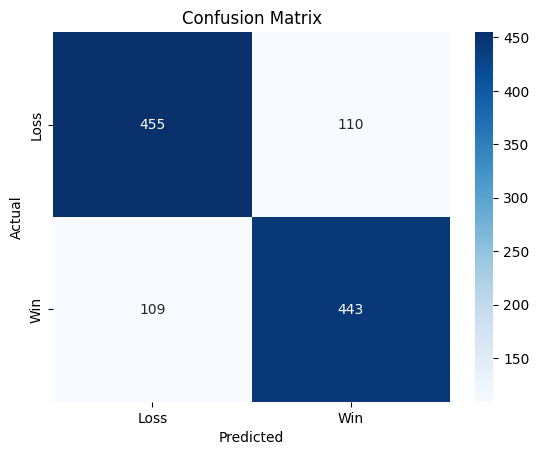

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       565
           1       0.80      0.80      0.80       552

    accuracy                           0.80      1117
   macro avg       0.80      0.80      0.80      1117
weighted avg       0.80      0.80      0.80      1117

Amount of features 22
(13322, 532)


In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model using the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))
print("Amount of features", len(suffixed_features))

print(mma_dataframe.shape) 
#sns.pairplot(data, hue = 'result')

/home/vaino/.local/lib/python3.12/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 4458, number of negative: 4582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4473
[LightGBM] [Info] Number of data points in the train set: 9040, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493142 -> initscore=-0.027435
[LightGBM] [Info] Start training from score -0.027435
Accuracy on test set: 0.7977


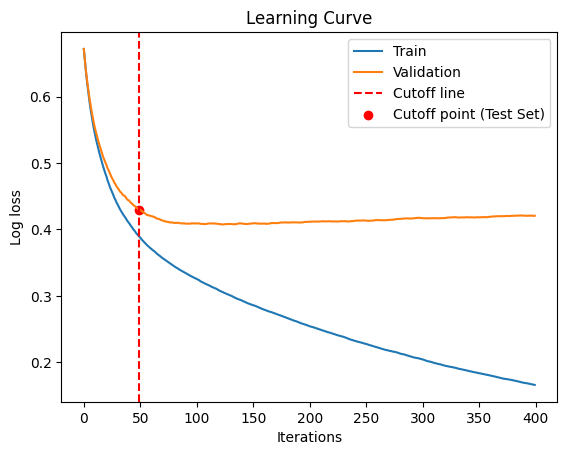

In [5]:
#Figure Log loss plot (learning curve)

# Define parameters for LightGBM model
NUM_ITERATIONS = 400
LEARNING_RATE = 0.06
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_iterations': NUM_ITERATIONS,
    'learning_rate': LEARNING_RATE,
}

train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val, reference=train_data)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

# Lists to store evaluation results
evals_result_train = {'train_acc': []}
evals_result_val = {'val_acc': []}
evals_result_test = {'test_acc': []}

# Custom callback function to collect evaluation results
def validation_callback(env):
    train_metric = env.evaluation_result_list[0][2]
    val_metric = env.evaluation_result_list[1][2]
    test_metric = env.evaluation_result_list[2][2]
    evals_result_train['train_acc'].append(train_metric)
    evals_result_val['val_acc'].append(val_metric)
    evals_result_test['test_acc'].append(test_metric)

# # Train the model with the validation callback
model = lgb.train(params, train_data, valid_sets=[train_data, val_data, test_data], num_boost_round=100, callbacks=[validation_callback])
# 
# # Get predictions on the test set
y_pred = model.predict(x_test, num_iteration=model.best_iteration)
y_pred_class = np.round(y_pred)

# Calculate and print accuracy on the test set
accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy on test set: {accuracy:.4f}')

# Calculate the gradient of the train accuracy curve
grad_train_acc = np.gradient(evals_result_train['train_acc'])

# Define the threshold percentage for determining the flat region
threshold_percentage = 0.1

# Find the index where the gradient is below the threshold
cutoff_point_index = np.where(np.abs(grad_train_acc) < threshold_percentage * np.max(np.abs(grad_train_acc)))[0][0]

# Plot the accuracy over iterations
plt.plot(evals_result_train['train_acc'], label='Train')
plt.plot(evals_result_val['val_acc'], label='Validation')
#plt.plot(evals_result_test['test_acc'], label='Test')
plt.axvline(x=cutoff_point_index, color='red', linestyle='--', label='Cutoff line')

# Plot a marker for the cutoff point
plt.scatter(cutoff_point_index, evals_result_test['test_acc'][cutoff_point_index], color='red', marker='o', label='Cutoff point (Test Set)')

plt.xlabel('Iterations')
plt.ylabel('Log loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

/home/vaino/.local/lib/python3.12/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Length of labels differs from the length of #data


[LightGBM] [Info] Number of positive: 4822, number of negative: 4944
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4475
[LightGBM] [Info] Number of data points in the train set: 9766, number of used features: 22


LightGBMError: Length of labels differs from the length of #data

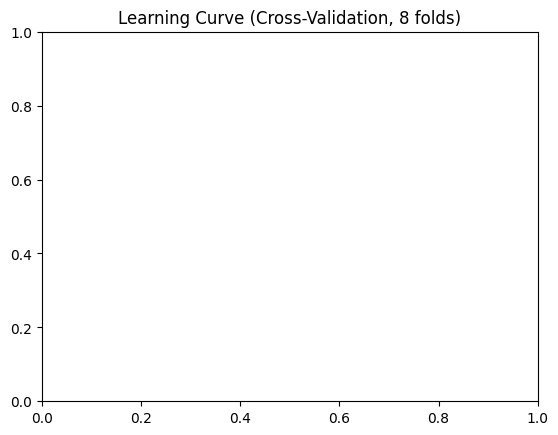

In [8]:
# Figure cross validation of log loss

NUM_FOLDS = 8
plt.title(f'Learning Curve (Cross-Validation, {NUM_FOLDS} folds)')

# Perform k-fold cross-validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Lists to store evaluation results for multiple runs
evals_results_train = []
evals_results_val = []
evals_results_test = []

# Train the model and collect evaluation results for each fold
for train_index, val_index in kf.split(X):
    x_train, x_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    train_data = lgb.Dataset(x_train, label=y_train, free_raw_data=False)
    val_data = lgb.Dataset(x_val, label=y_val, reference=train_data, free_raw_data=False)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data, free_raw_data=False)

    evals_result_train = {}
    evals_result_val = {}
    evals_result_test = {}
    
    # Custom callback function to collect evaluation results during training
    def evaluation_callback(env):
        iteration = env.iteration
        train_loss = env.evaluation_result_list[0][2]
        val_loss = env.evaluation_result_list[1][2]
        test_loss = env.evaluation_result_list[2][2]
        evals_result_train[iteration] = train_loss
        evals_result_val[iteration] = val_loss
        evals_result_test[iteration] = test_loss
    
    # Train the model with the custom evaluation callback
    model = lgb.train(params, train_data, valid_sets=[train_data, val_data, test_data], valid_names=['train', 'val', 'test'],
                      num_boost_round=NUM_ITERATIONS, callbacks=[evaluation_callback])
    
    # Store evaluation results for this fold
    evals_results_train.append([evals_result_train[i] for i in range(NUM_ITERATIONS)])
    evals_results_val.append([evals_result_val[i] for i in range(NUM_ITERATIONS)])
    evals_results_test.append([evals_result_test[i] for i in range(NUM_ITERATIONS)])

# Convert lists to arrays
evals_results_train = np.array(evals_results_train)
evals_results_val = np.array(evals_results_val)
evals_results_test = np.array(evals_results_test)

# Calculate mean and standard deviation of evaluation results over folds
mean_train_loss = np.mean(evals_results_train, axis=0)
mean_val_loss = np.mean(evals_results_val, axis=0)
mean_test_loss = np.mean(evals_results_test, axis=0)
std_train_loss = np.std(evals_results_train, axis=0)
std_val_loss = np.std(evals_results_val, axis=0)
std_test_loss = np.std(evals_results_test, axis=0)

# Plot the mean log loss over iterations with standard deviation as shading
plt.plot(mean_train_loss, label='Train')
plt.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3)
plt.plot(mean_val_loss, label='Validation')
plt.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3)
#plt.plot(mean_test_loss, label='Test')
#plt.fill_between(range(len(mean_test_loss)), mean_test_loss - std_test_loss, mean_test_loss + std_test_loss, alpha=0.3)

# Calculate the gradient of the train loss curve
grad_mean_test_loss = np.gradient(mean_test_loss)

# Define the threshold percentage for determining the flat region
threshold_percentage = 0.1

# Find the index where the gradient is below the threshold for train curve
cutoff_point_index = np.where(np.abs(grad_mean_test_loss) < threshold_percentage * np.max(np.abs(grad_mean_test_loss)))[0][0]

# Plot a marker for the cutoff point on train curve
plt.scatter(cutoff_point_index, mean_test_loss[cutoff_point_index], color='red', marker='o', label='Cutoff point (Test Set)')

# Plot a vertical line through the cutoff point
plt.axvline(x=cutoff_point_index, color='red', linestyle='--', label='Cutoff line')

plt.xlabel('Iterations')
plt.ylabel('Log loss')
plt.ylim(0.2, 0.7)
plt.legend()
plt.show()

# Print the standard deviation of the test results
print(f'Standard deviation of test results: {np.mean(std_test_loss)}')


In [9]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# Define your data X and Y here
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# List of classifiers
classifiers = {
    "LightGBM": lgb.LGBMClassifier(n_estimators=100),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100),
    "NeuralNetwork": MLPClassifier(max_iter=1000),
    "SVC": SVC(probability=True) # Use probability=True for SVC to get probabilities for log loss calculation
}

# Figure cross validation of log loss
NUM_FOLDS = 8
plt.title(f'Learning Curve (Cross-Validation, {NUM_FOLDS} folds)')

# Perform k-fold cross-validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Lists to store evaluation results for multiple runs
evals_results_train = {clf_name: [] for clf_name in classifiers}
evals_results_val = {clf_name: [] for clf_name in classifiers}
evals_results_test = {clf_name: [] for clf_name in classifiers}

# Train the model and collect evaluation results for each fold
for train_index, val_index in kf.split(X_train):
    x_train, x_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    for clf_name, clf in classifiers.items():
        clf.fit(x_train, y_train_fold)

        # Store evaluation results for this fold
        evals_results_train[clf_name].append(clf.score(x_train, y_train_fold))
        evals_results_val[clf_name].append(clf.score(x_val, y_val_fold))
        evals_results_test[clf_name].append(clf.score(X_test, y_test))

# Convert lists to arrays
for clf_name in classifiers:
    evals_results_train[clf_name] = np.array(evals_results_train[clf_name])
    evals_results_val[clf_name] = np.array(evals_results_val[clf_name])
    evals_results_test[clf_name] = np.array(evals_results_test[clf_name])

# Calculate mean and standard deviation of evaluation results over folds for each classifier
mean_train_loss = {clf_name: np.mean(evals_results_train[clf_name], axis=0) for clf_name in classifiers}
mean_val_loss = {clf_name: np.mean(evals_results_val[clf_name], axis=0) for clf_name in classifiers}
mean_test_loss = {clf_name: np.mean(evals_results_test[clf_name], axis=0) for clf_name in classifiers}
std_train_loss = {clf_name: np.std(evals_results_train[clf_name], axis=0) for clf_name in classifiers}
std_val_loss = {clf_name: np.std(evals_results_val[clf_name], axis=0) for clf_name in classifiers}
std_test_loss = {clf_name: np.std(evals_results_test[clf_name], axis=0) for clf_name in classifiers}

# Plot the mean log loss over iterations with standard deviation as shading for each classifier
for clf_name in classifiers:
    plt.plot(mean_train_loss[clf_name], label=f'{clf_name} Train')
    plt.fill_between(range(len(mean_train_loss[clf_name])), mean_train_loss[clf_name] - std_train_loss[clf_name], mean_train_loss[clf_name] + std_train_loss[clf_name], alpha=0.3)
    plt.plot(mean_val_loss[clf_name], label=f'{clf_name} Validation')
    plt.fill_between(range(len(mean_val_loss[clf_name])), mean_val_loss[clf_name] - std_val_loss[clf_name], mean_val_loss[clf_name] + std_val_loss[clf_name], alpha=0.3)
    plt.plot(mean_test_loss[clf_name], label=f'{clf_name} Test')
    plt.fill_between(range(len(mean_test_loss[clf_name])), mean_test_loss[clf_name] - std_test_loss[clf_name], mean_test_loss[clf_name] + std_test_loss[clf_name], alpha=0.3)

    # Plotting red points for the test set accuracy
    for i, acc in enumerate(mean_test_loss[clf_name]):
        plt.scatter(i, acc, color='red')
        plt.text(i, acc, f'(acc: {acc:.2f})', fontsize=8, ha='right')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim(0.2, 1.0)
plt.legend()
plt.show()

# Print the standard deviation of the test results
print(f'Standard deviation of test results: {np.mean(std_test_loss)}')

[LightGBM] [Info] Number of positive: 3851, number of negative: 3961
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4469
[LightGBM] [Info] Number of data points in the train set: 7812, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492960 -> initscore=-0.028164
[LightGBM] [Info] Start training from score -0.028164
[LightGBM] [Info] Number of positive: 3856, number of negative: 3957
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4470
[LightGBM] [Info] Number of data points in the train set: 7813, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493536 -> initscore=-0.025856
[LightGBM] [Info] Start training from score -0.025856
[LightGBM] [Info] 